**Objective:**
To categorise the countries using socio-economic and health factors that determine the overall development of the country.

**About organization:**
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

**Problem Statement:**
HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.


**Solution** 
We will use the concept of clustering in Unsupervised Learning and will try to find out the group of countries which need the funds most and also give the detailed analysis report. We will also create an application for the NGO, where they need to enter the details(Social Economic Data) and it will predict what cluster this data belongs a

**DATA DICTIONARY**
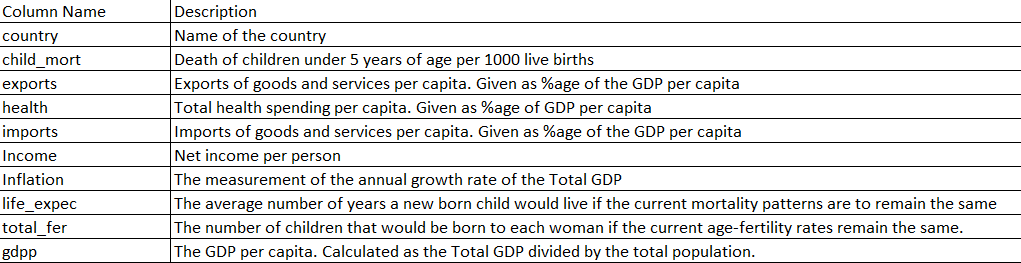

In [64]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.decomposition import PCA
import plotly.express as px
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
data.set_index('country',inplace = True)
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


In [4]:
print('No of countries:',data.shape[0])
print('No of columns:',data.shape[1])

No of countries: 167
No of columns: 9


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB


In [6]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


<Axes: >

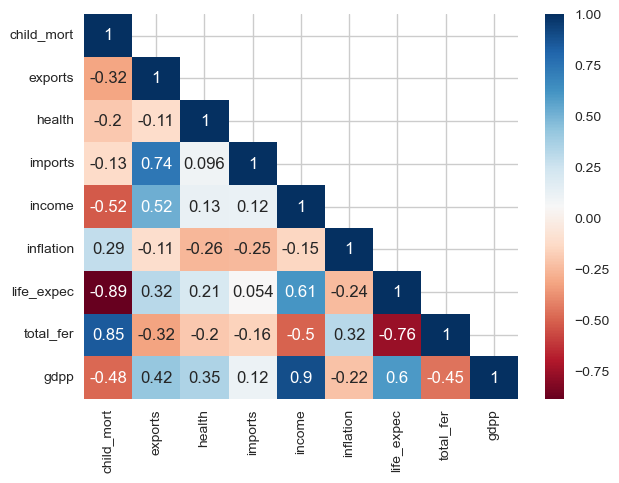

In [7]:
#Lets look at the correlation map to identify any significant correlations
plt.figure(figsize=(7,5))
sns.heatmap(data.corr(),annot = True,vmax=1,cmap ='RdBu',mask=np.triu(data.corr(),k=1))

## Visualization

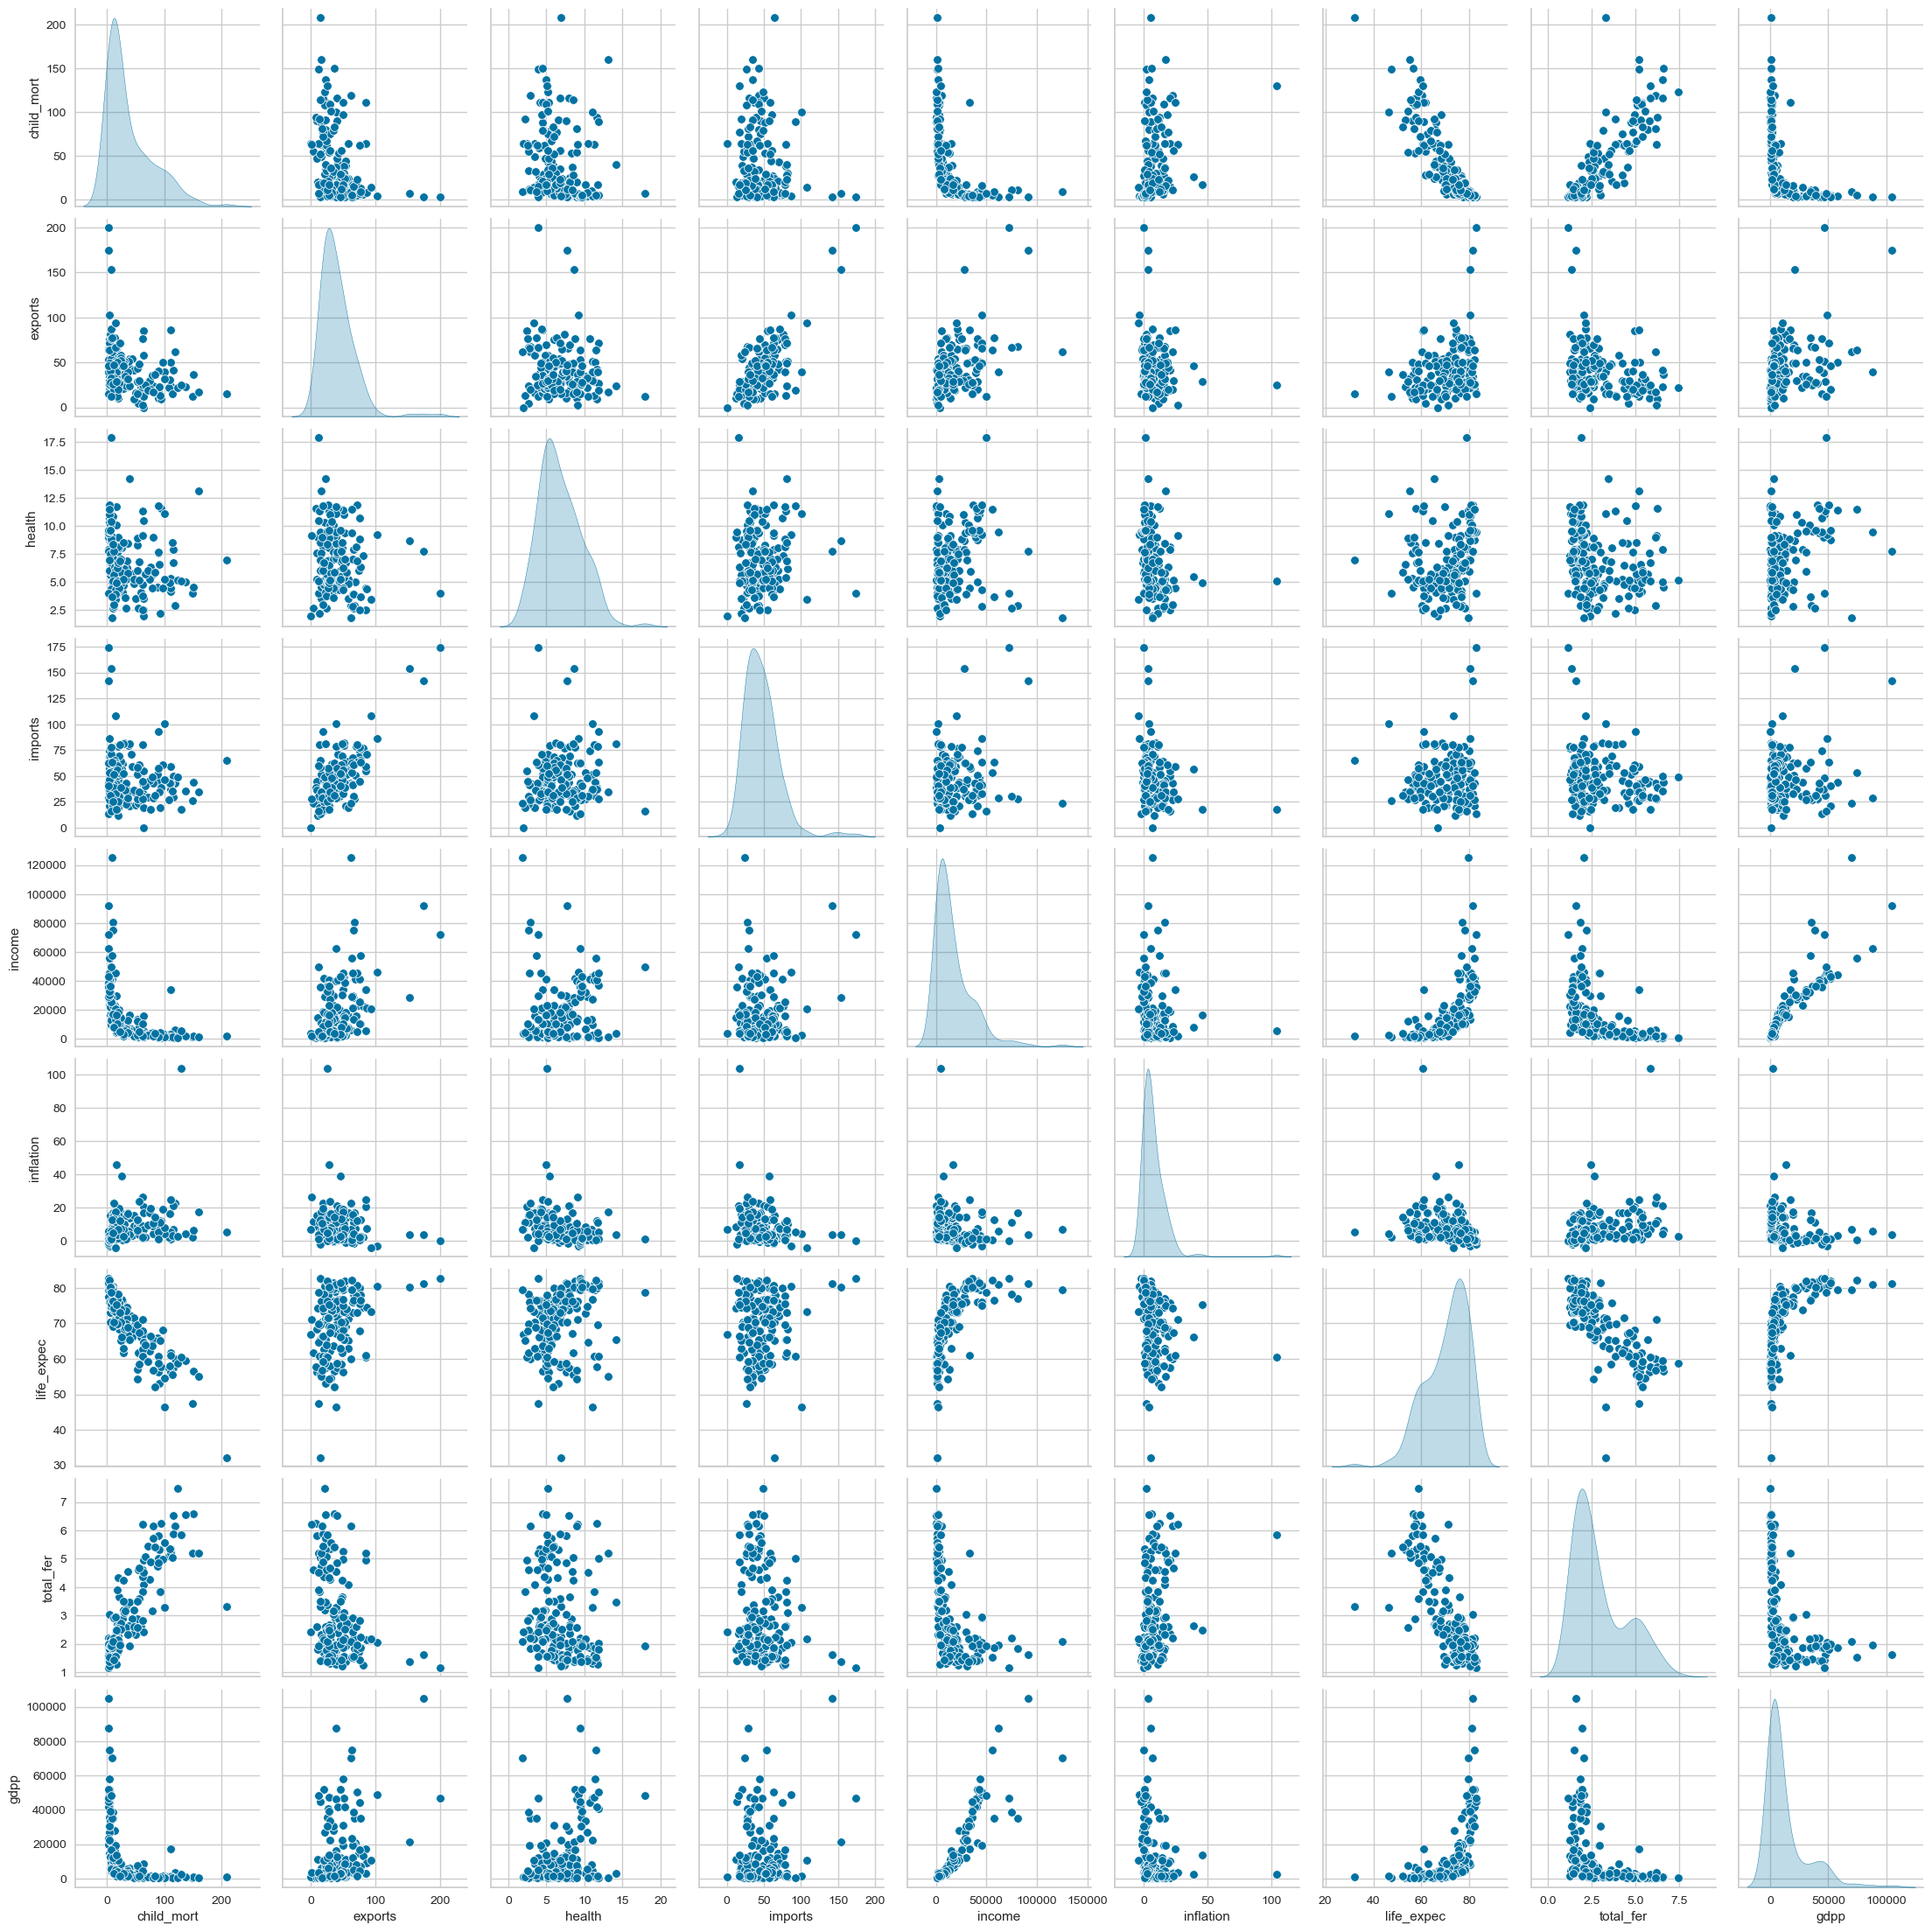

In [8]:
sns.pairplot(data,diag_kind='kde')
plt.show()

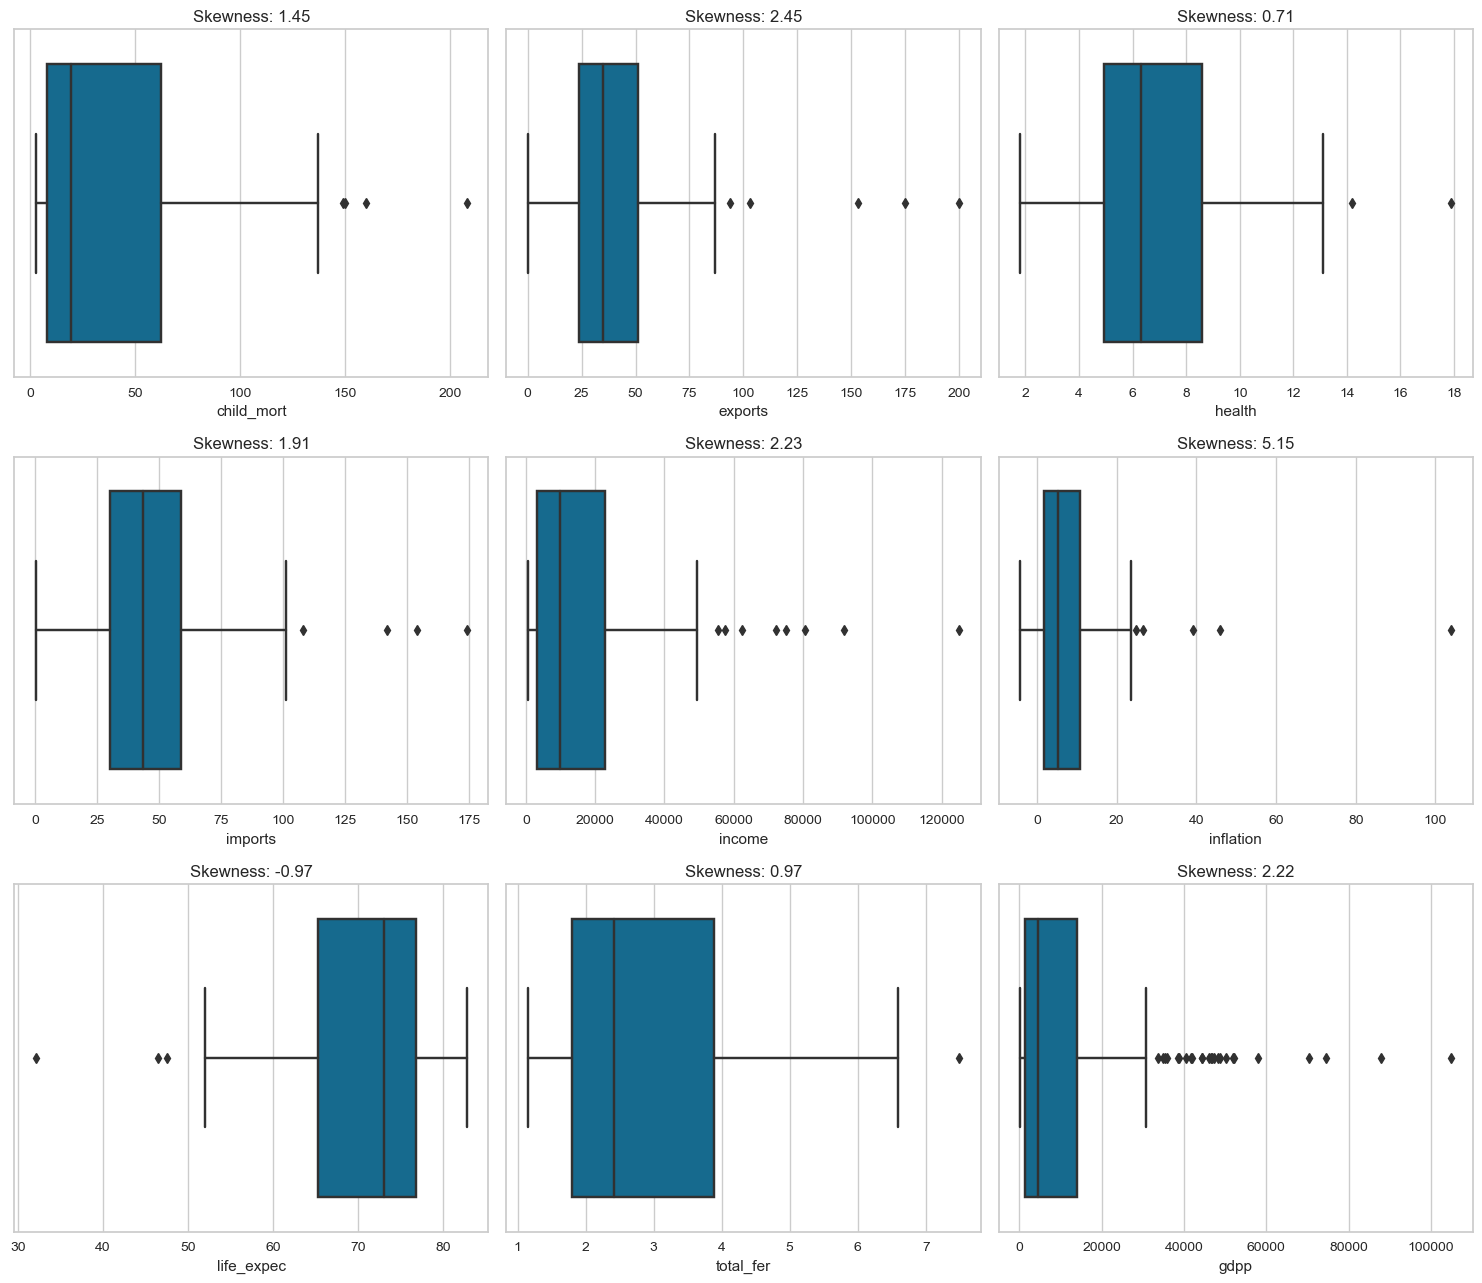

In [9]:
# Explore the skewness and outliers using Boxplot

t = 1
plt.figure(figsize=(15,13))
for i in data:
    plt.subplot(3,3,t)
    sns.boxplot(data, x = i)
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

## preprocessing

In [10]:
# Check for missing values
data.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [11]:
data.duplicated().sum()

0

In [12]:
# Outliers Treatment
# Lets cap the outliers

for i in data:
    q3,q1 = np.quantile(data[i] , [.75,.25])
    iqr = q3-q1
    ul,ll = q3 + 2 * iqr, q1 - 2 * iqr
    data[i] = data[i].apply(lambda x: ll if x < ll else ul if x > ul else x)

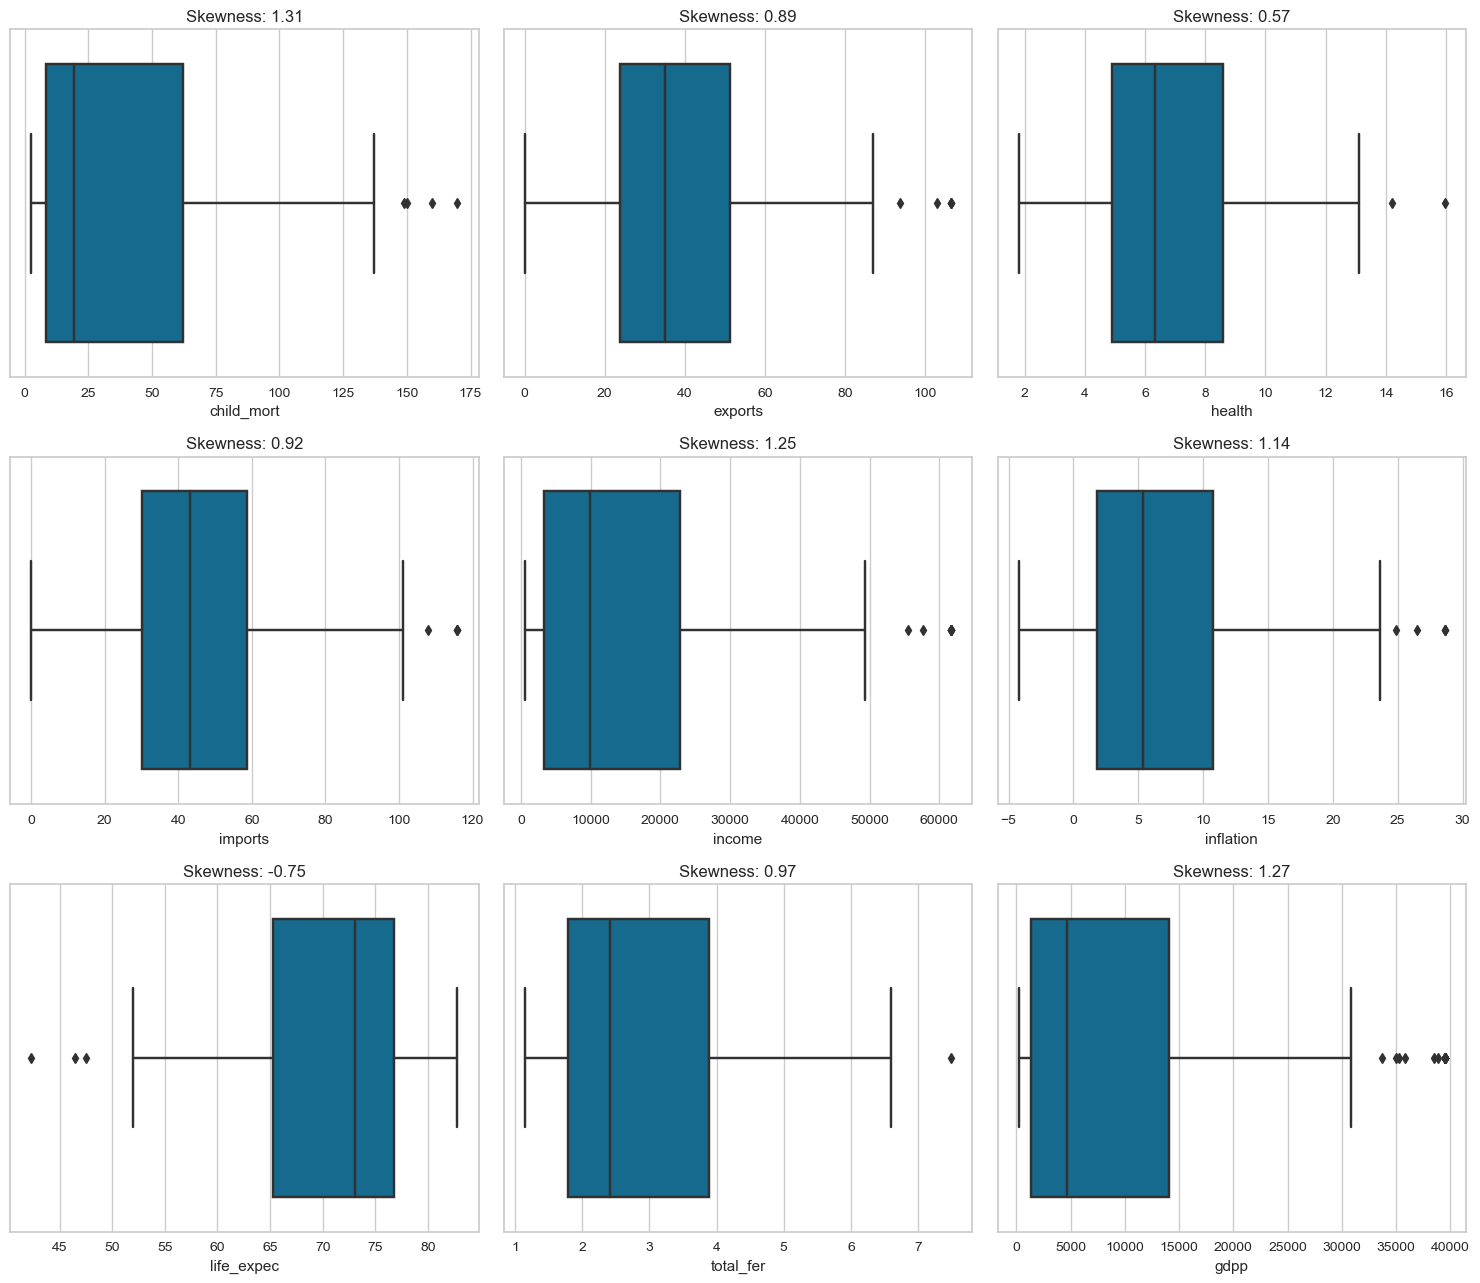

In [13]:
t = 1
plt.figure(figsize=(15,13))
for i in data:
    plt.subplot(3,3,t)
    sns.boxplot(data, x = i)
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [14]:
scaler = StandardScaler()
data_s = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

In [15]:
data_s

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.325807,-1.350898,0.287879,-0.059395,-0.908259,0.327015,-1.669872,1.902882,-0.800533
1,-0.545011,-0.536547,-0.094264,0.115438,-0.394747,-0.384140,0.658280,-0.859973,-0.534220
2,-0.273031,-0.066034,-0.977272,-0.697302,-0.211439,1.283842,0.681446,-0.038404,-0.506362
3,2.057866,1.015243,-1.467008,-0.153900,-0.643479,2.188949,-1.218141,2.128151,-0.576385
4,-0.705149,0.255182,-0.287190,0.602137,0.171226,-0.822326,0.716194,-0.541946,0.076410
...,...,...,...,...,...,...,...,...,...
162,-0.224735,0.304948,-0.576579,0.309173,-0.825554,-0.652799,-0.882238,0.365754,-0.618549
163,-0.532302,-0.513926,-0.702723,-1.349384,0.010754,3.083999,0.554034,-0.316678,0.174291
164,-0.374705,1.454087,0.013330,1.608612,-0.730505,0.709171,0.287629,-0.661206,-0.743536
165,0.464112,-0.446064,-0.602550,-0.555545,-0.731122,2.361350,-0.361010,1.140944,-0.743536


## Reduce the data using PCA

In [16]:
pca = PCA(n_components=9)
pca.fit(data_s)

PCA(n_components=9)

In [17]:
# As per kasier criterion we can have 3 PC's
pca.explained_variance_   #eigen values

array([4.36078478, 1.50181611, 1.23490898, 0.89728681, 0.59365874,
       0.1966251 , 0.14870828, 0.08513501, 0.03529306])

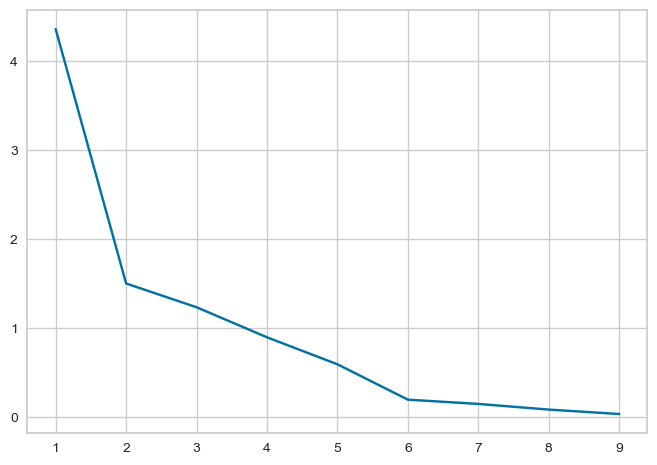

In [18]:
# Lets see scree plot

plt.plot(range(1,10),pca.explained_variance_)

In [19]:
# explained variance ratio
# Lets use pc that explains 95% variance
pca.explained_variance_ratio_.cumsum()

array([0.48163025, 0.6474995 , 0.78388998, 0.88299152, 0.94855862,
       0.97027503, 0.98669923, 0.99610203, 1.        ])

Lets go with 5 Principal components as they explain ~95% variation in the data

In [20]:
pca_final = PCA(n_components=5)
pca_data = pd.DataFrame(pca_final.fit_transform(data_s),columns=range(1,6))
pca_data.head()

,1,2,3,4,5
0,-3.099217,-0.232689,-0.972447,0.787536,-0.009905
1,0.427427,-0.285346,-0.242571,-1.377388,0.114011
2,-0.411658,-0.526613,1.634043,-0.613283,0.459962
3,-3.217072,1.229145,1.983955,1.635771,0.159702
4,1.189011,0.479460,-0.151955,-0.774114,-0.382475


### K means clustering

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=10))

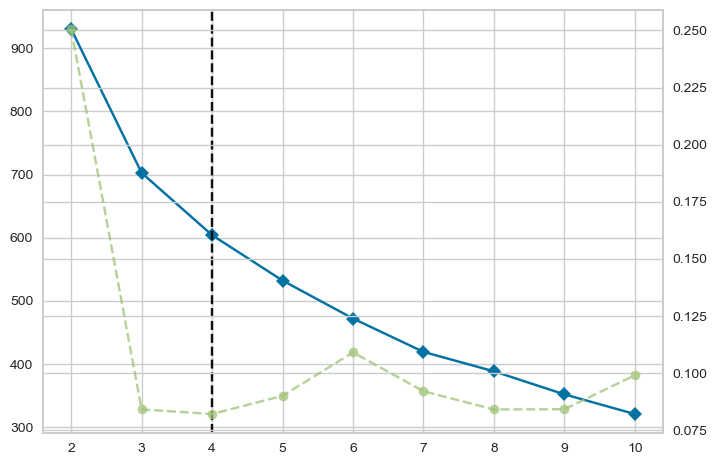

In [21]:
# Lets decide the value of k

#K-elbow plot
kelbow = KElbowVisualizer(estimator=KMeans(),k=10)
kelbow.fit(pca_data)

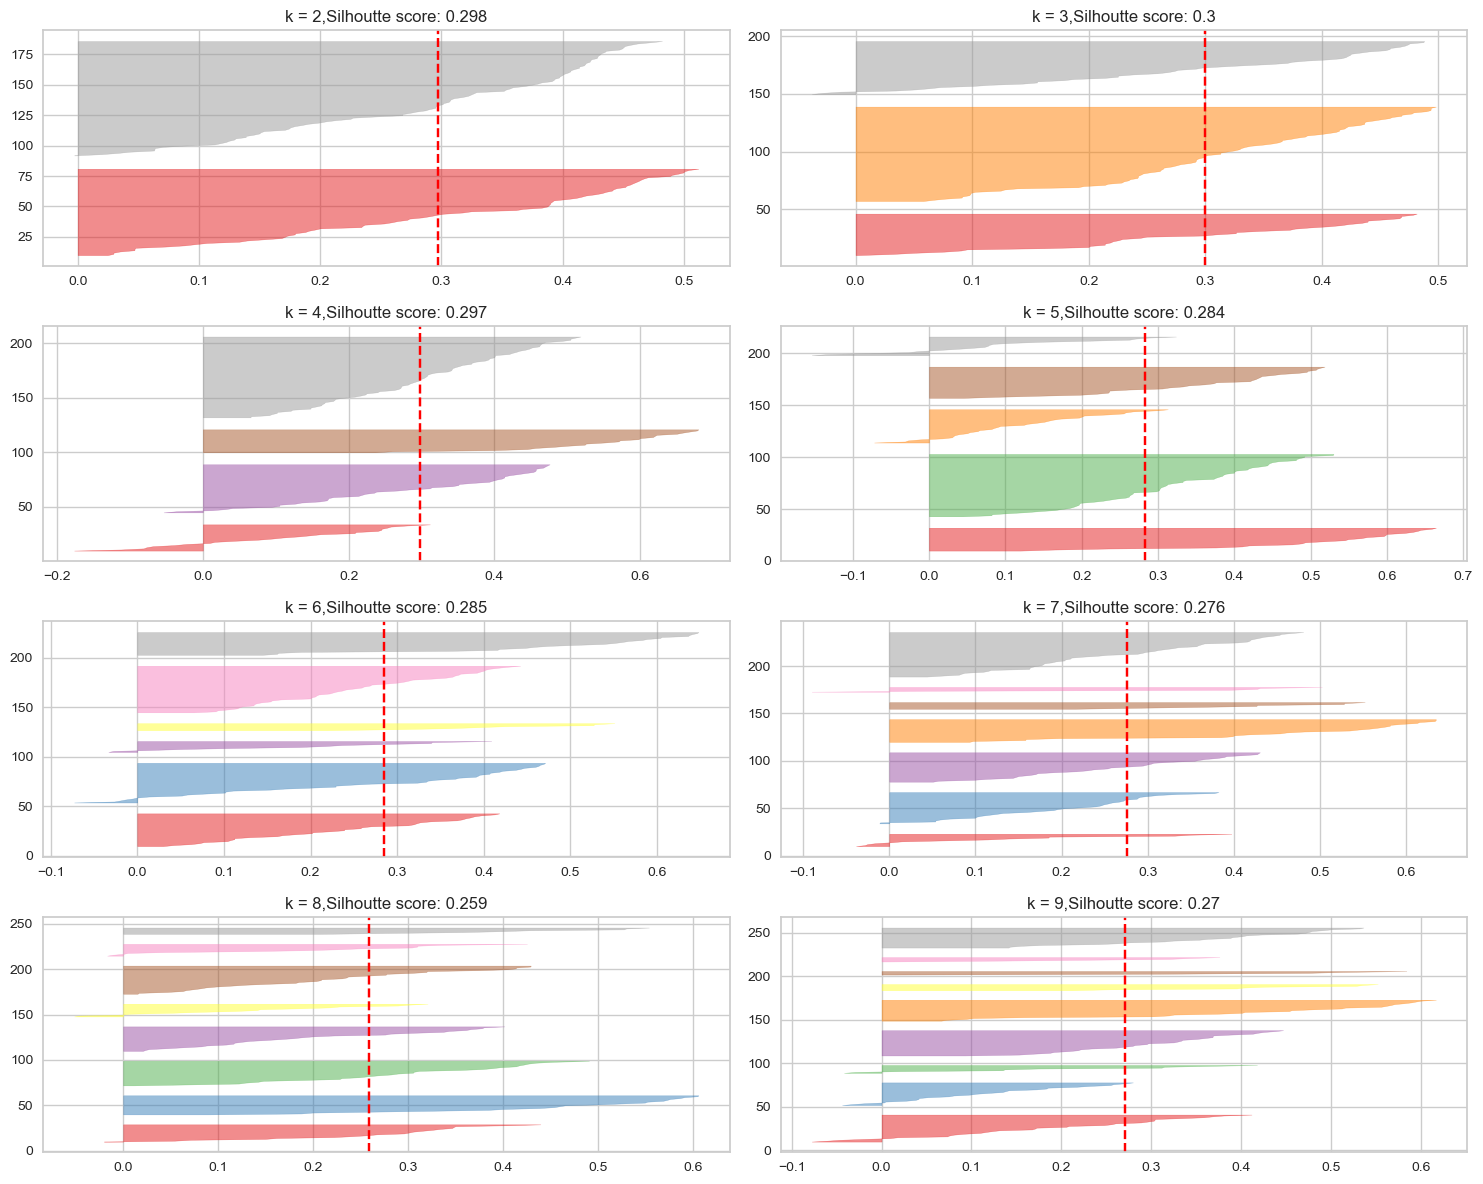

In [22]:
# silhoutte visualizer

t = 1
plt.figure(figsize=(15,12))
for i in range(2,10):
    plt.subplot(4,2,t)
    model = KMeans(n_clusters = i)
    sil_viz = SilhouetteVisualizer(estimator=model)
    sil_viz.fit(pca_data)
    plt.title(f'k = {i},Silhoutte score: {round(sil_viz.silhouette_score_,3)}')
    t+=1
plt.tight_layout()
plt.show()

k = 2 and k =3 are giving better reslts. But silhoutte score is slightly better in K=3 also the clusters that are formed have fairly good distribution. Let's go with k = 3

In [38]:
kmeans = KMeans(n_clusters=3,random_state=2)
label = kmeans.fit_predict(pca_data)
label

array([0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2,
       2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1,
       1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2,
       0, 2, 1, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 0,
       0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
       1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 2, 0, 2, 2,
       0, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0])

In [39]:
data['Label'] = label

In [40]:
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,0
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,2


In [41]:
data['Label'].value_counts()

Label
2    83
0    47
1    37
Name: count, dtype: int64

In [47]:
centroids = kmeans.cluster_centers_
centroids

array([[-2.56511471,  0.09977044, -0.20246215,  0.64201088, -0.15548257],
       [ 2.86681026, -0.35670063, -0.14254351,  0.83051233, -0.23432848],
       [ 0.17455918,  0.10251461,  0.17819073, -0.73377672,  0.19250403]])

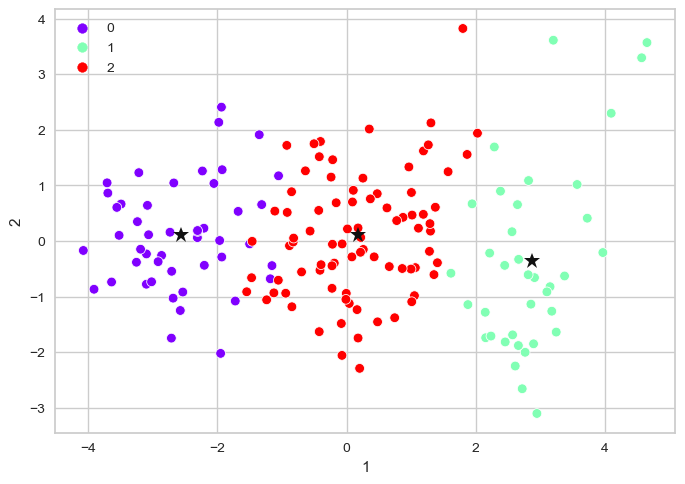

In [48]:
sns.scatterplot(data = pca_data, x = 1, y = 2,hue = label,palette='rainbow')
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],color = 'k',marker = '*', ms=12)
plt.show()

## Business interpretations

In [42]:
data.groupby('Label').mean().T

Label,0,1,2
child_mort,92.402128,5.237838,21.881928
exports,28.225936,52.458108,40.831084
health,6.253830,8.730541,6.256867
imports,41.233317,47.971622,48.136145
income,3738.574468,41360.540541,12293.373494
inflation,10.376064,2.588432,7.384446
life_expec,59.610638,79.956757,72.685542
total_fer,4.998085,1.755676,2.318554
gdpp,1808.297872,34073.243243,6291.855422


In [43]:
data['Label'] = data['Label'].map({0:'UnderDeveloped', 1 : 'Developed', 2 :'Developing'})

In [44]:
# Developed countries

data[data['Label'] == 'Developed'].index.to_list()

['Australia',
 'Austria',
 'Bahamas',
 'Bahrain',
 'Belgium',
 'Brunei',
 'Canada',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Iceland',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Portugal',
 'Qatar',
 'Singapore',
 'Slovak Republic',
 'Slovenia',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Arab Emirates',
 'United Kingdom',
 'United States']

In [45]:
data[data['Label'] == 'Developing'].index.to_list()

['Albania',
 'Algeria',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Azerbaijan',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belize',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Cambodia',
 'Cape Verde',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Fiji',
 'Georgia',
 'Grenada',
 'Guatemala',
 'Guyana',
 'Hungary',
 'India',
 'Indonesia',
 'Iran',
 'Jamaica',
 'Jordan',
 'Kazakhstan',
 'Kyrgyz Republic',
 'Latvia',
 'Lebanon',
 'Libya',
 'Lithuania',
 'Macedonia, FYR',
 'Malaysia',
 'Maldives',
 'Mauritius',
 'Micronesia, Fed. Sts.',
 'Moldova',
 'Mongolia',
 'Montenegro',
 'Morocco',
 'Nepal',
 'Oman',
 'Panama',
 'Paraguay',
 'Peru',
 'Philippines',
 'Poland',
 'Romania',
 'Russia',
 'Samoa',
 'Saudi Arabia',
 'Serbia',
 'Seychelles',
 'Solomon Islands',
 'Sri Lanka',
 'St. Vincent and the Grenadines',
 'Suriname',
 'Tajikistan',
 'Thailand',
 '

In [46]:
data[data['Label'] == 'UnderDeveloped'].index.to_list()

['Afghanistan',
 'Angola',
 'Benin',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Equatorial Guinea',
 'Eritrea',
 'Gabon',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Kenya',
 'Kiribati',
 'Lao',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mozambique',
 'Myanmar',
 'Namibia',
 'Niger',
 'Nigeria',
 'Pakistan',
 'Rwanda',
 'Senegal',
 'Sierra Leone',
 'South Africa',
 'Sudan',
 'Tanzania',
 'Timor-Leste',
 'Togo',
 'Uganda',
 'Yemen',
 'Zambia']

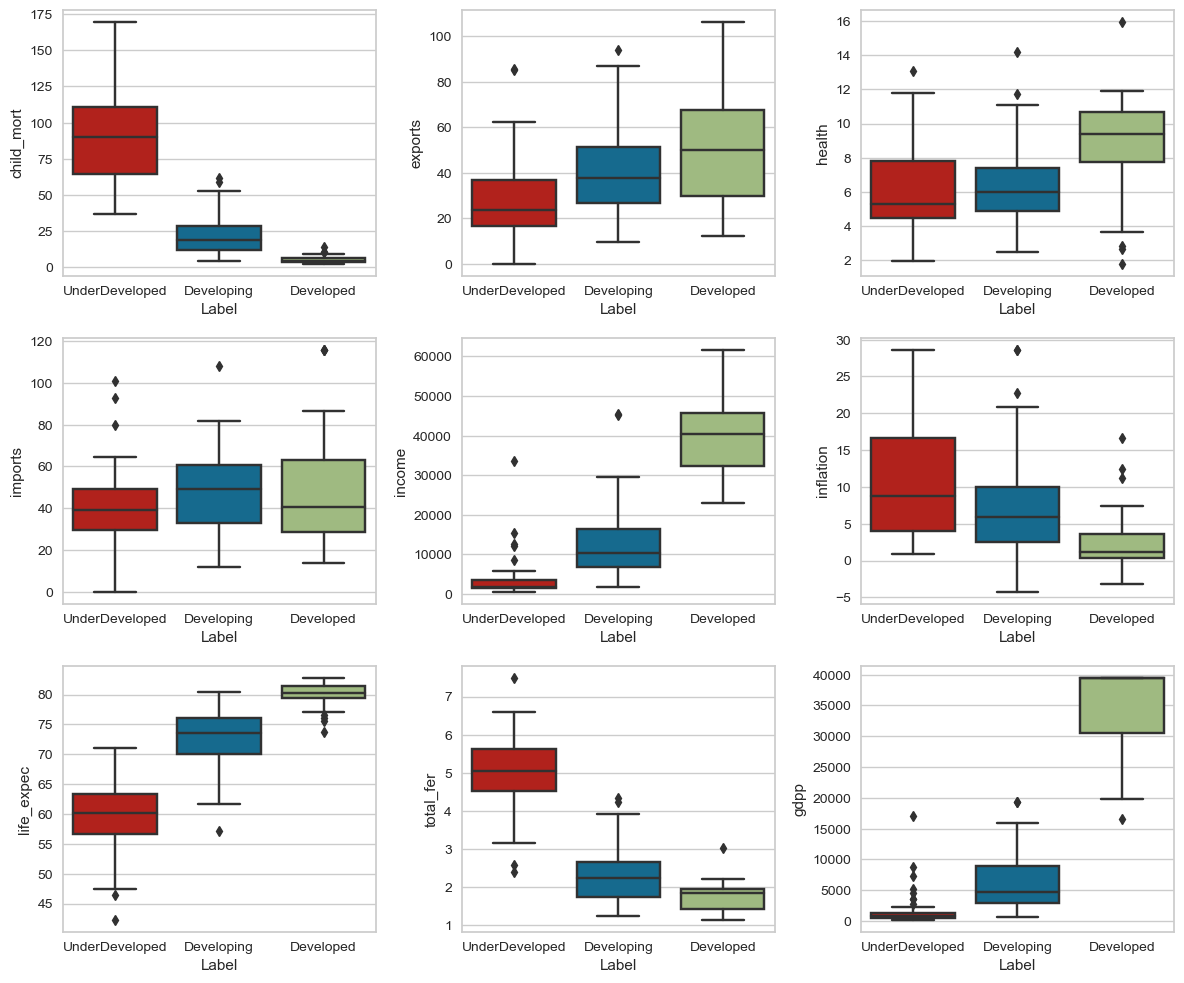

In [53]:
# lets visualize the clusters
t = 1
plt.figure(figsize=(12,10))
for i in data.columns:
    if i != 'Label':
        plt.subplot(3,3,t)
        sns.boxplot(data, y = i, x = 'Label',palette=['r','b','g'])
        t+=1
plt.tight_layout()
plt.show()

In [58]:
px.choropleth(data_frame=data,locationmode='country names',locations=data.index,color='Label',
              color_discrete_map={'Developed' :'green',
                                 'Developing' :'blue',
                                 'UnderDeveloped': 'red'})

## Deployment

In [59]:
pca_data.head(2)

,1,2,3,4,5
0,-3.099217,-0.232689,-0.972447,0.787536,-0.009905
1,0.427427,-0.285346,-0.242571,-1.377388,0.114011


In [61]:
kmeans.predict([[-3.099217,-0.232689,-0.972447,0.787536,-0.009905]])

array([0])

In [62]:
kmeans.predict([[0.427427,-0.285346,-0.242571,-1.377388,0.114011]])

array([2])

In [65]:
# Lets download the instances that we require to deploy

with open('scaler.pkl','wb') as file:
    pickle.dump(scaler,file)

with open('pca.pkl','wb') as file:
    pickle.dump(pca_final,file)

with open('model.pkl','wb') as file:
    pickle.dump(kmeans,file)